In [1]:
import json
import os
import sys
from math import *
wd = os.path.abspath(os.getcwd()) # os.path.dirname(os.path.dirname(os.getcwd()))
wd = os.path.dirname(wd)
sys.path.append(wd+"\\src")
import numpy as np
from functional import seq
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [2]:
from gaslayer import GasFluxCalculator, GasEOS, GasLayer,GridStrecher,Powder,PowderOvLayer,ElPistEOS, ElPistLayer

In [3]:
from tube import Tube

In [4]:
with open('gpowders.json') as f:
    all_powders = json.load(f)

In [5]:
all_powders[r'4\7']

{'name': '4\\7',
 'f': 1.027,
 'etta': 0.228,
 'alpha_k': 1.008,
 'T_1': 3006.0,
 'ro': 1.6,
 'I_k': 0.32,
 'Z_k': 1.488,
 'k_1': 0.811,
 'lambda_1': 0.081,
 'k_2': 0.505,
 'lambda_2': -1.024,
 'k_f': 0.0003,
 'k_l': 0.0016}

In [6]:
powder_eos = Powder.from_bd(all_powders[r'4\7'])

In [7]:
flux_calculator = GasFluxCalculator()
grid_strecher = GridStrecher()

In [8]:
d = 23 * 1e-3
tube = Tube([0,1], [d, d])

In [9]:
omega = 30 * 1e-3
q = 170 *1e-3
delta = 700
p_ign = 5e6
pf = 300E6
W_0 = omega/delta
x0 = 0
x1 = tube.get_x2(x0,W_0)
x1

0.10315200200386698

In [10]:
n_cells = 100
layer = PowderOvLayer(n_cells=n_cells, tube=tube, powder=powder_eos, flux_calculator=flux_calculator, grid_strecher=grid_strecher)
layer.xs_borders = np.linspace(x0, x1, n_cells+1)
def foo(x, *args):
    return delta, p_ign, 0, 0
layer.init_ropue_fromfoo(foo)
layer.init_taus_acustic()

In [11]:
def get_V(tau: float, lr: PowderOvLayer):
    v_right = lr.Vs_borders[-1]
    p_right = lr.ps[-1]
    x_right = lr.xs_borders[-1]
    if p_right > pf or abs(v_right) > 1e-3:
        a = lr.S[-1] * p_right / q
        return v_right + tau * a
    return v_right

In [12]:
courant = 0.5
layers_all = []
while layer.xs_borders[-1] < 1:
    layers_all.append(layer)
    tau = layer.get_tau_min() * courant
    vr = get_V(tau, layer)
    layer1 = layer.step_simple(tau, 0, vr)
    if layer == layer1:
        break
    layer = layer1

In [13]:
dicts_all = seq(layers_all).map(lambda lr: lr.to_dict()).to_list()

In [14]:
ts = seq(dicts_all).map(lambda d: d['time']).to_list()
p_snar = seq(dicts_all).map(lambda d: d['ps'][-1]).to_list()
p_dno =  seq(dicts_all).map(lambda d: d['ps'][0]).to_list()
v_snar = seq(dicts_all).map(lambda d: d['Vs_borders'][-1]).to_list()

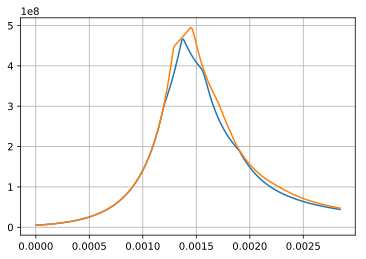

In [15]:
plt.plot(ts, p_snar)
plt.plot(ts, p_dno)
plt.grid()
plt.show()

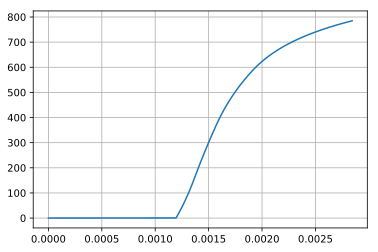

In [16]:
plt.plot(ts, v_snar)
plt.grid()
plt.show()

### Газ

### Поршень по инерции

In [17]:
d1 = 23 * 1e-3
d2 = 14 * 1e-3
l_pist = 100 * 1e-3
tube_el = Tube([0, 2*l_pist, 2*l_pist+l_pist], [d1,d1,d2])

In [18]:
el_pist_eos = ElPistEOS()
flux_calculator_el = GasFluxCalculator()
grid_strecher_el = GridStrecher()

In [66]:
n_cells_el = 100
el_layer=ElPistLayer(n_cells=n_cells_el,
                     tube=tube_el, 
                     epistEOS=el_pist_eos, 
                     flux_calculator=flux_calculator_el, 
                     grid_strecher=grid_strecher_el)

In [71]:
v0 = 900.0
m_left, m_right = 100 * 1e-3, 25 * 1e-3
el_layer.xs_borders=np.linspace(0,l_pist,n_cells_el+1)
el_layer.Vs_borders=np.repeat(v0, n_cells_el+1)
def foo_el(x, *args):
    ro = el_pist_eos.ro_0+100
    p = el_pist_eos.get_p(ro, 1000000)
    return ro, p, v0
el_layer.init_ropue_fromfoo(foo_el)
el_layer.init_taus_acustic()

In [72]:
def get_vleft_vright(tau: float, lr: ElPistLayer):
    p_left = lr.ps[0] #- lr.tauxx_flux[0]
    s_left = lr.S[0]
    a_left = -p_left*s_left / m_left
    v_left = lr.Vs_borders[0]
    
    p_r = lr.ps[-1] #- lr.tauxx_flux[-1]
    s_r = lr.S[-1]
    a_r = p_r*s_r / m_right
    v_r = lr.Vs_borders[-1]
    
    return v_left + tau*a_left, v_r + tau*a_r

In [94]:
ro = el_pist_eos.ro_0
e = el_pist_eos.get_p(ro, 100)
e 

-4895484036.784304

In [74]:
el_layer.to_dict()['ps']

array([-4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -4.25255505e+09, -4.25255505e+09, -4.25255505e+09,
       -4.25255505e+09, -

In [42]:
get_vleft_vright(el_layer.get_tau_min() * courant, el_layer)

(nan, nan)

In [32]:
courant = 0.1
el_layers_all = []
while el_layer.xs_borders[-1] < 2*l_pist+l_pist + l_pist:
    el_layers_all.append(el_layer)
    tau = el_layer.get_tau_min() * courant
    vl, vr = get_vleft_vright(tau, el_layer)
    layer1 = el_layer.step_simple(tau, vl, vr)
    if el_layer == layer1:
        break
    el_layer = layer1

In [34]:
el_layers_all[1-].to_dict()

{'time': 7.48561009651741e-08,
 'n_qs': 3,
 'xs_cells': array([0.00056741, 0.00156741, 0.0025674 , 0.0035674 , 0.0045674 ,
        0.0055674 , 0.0065674 , 0.00756739, 0.00856739, 0.00956739,
        0.01056739, 0.01156739, 0.01256739, 0.01356738, 0.01456738,
        0.01556738, 0.01656738, 0.01756738, 0.01856737, 0.01956737,
        0.02056737, 0.02156737, 0.02256737, 0.02356736, 0.02456736,
        0.02556736, 0.02656736, 0.02756736, 0.02856735, 0.02956735,
        0.03056735, 0.03156735, 0.03256735, 0.03356734, 0.03456734,
        0.03556734, 0.03656734, 0.03756734, 0.03856733, 0.03956733,
        0.04056733, 0.04156733, 0.04256733, 0.04356732, 0.04456732,
        0.04556732, 0.04656732, 0.04756732, 0.04856731, 0.04956731,
        0.05056731, 0.05156731, 0.05256731, 0.05356731, 0.0545673 ,
        0.0555673 , 0.0565673 , 0.0575673 , 0.0585673 , 0.05956729,
        0.06056729, 0.06156729, 0.06256729, 0.06356729, 0.06456728,
        0.06556728, 0.06656728, 0.06756728, 0.06856728, 0.069

In [55]:
vl

nan